In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import seaborn as sns

import tqdm
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail
import requests
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from adjustText import adjust_text
from io import BytesIO
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import time
from PIL import Image
from collections import defaultdict

from math import cos, sin, radians, sqrt, tan, atan, degrees

In [2]:
from nba_api.stats.endpoints.playbyplayv2 import PlayByPlayV2

from nba_api.stats.endpoints.playbyplay import PlayByPlay
from nba_api.stats.endpoints.leaguegamefinder import LeagueGameFinder
from nba_api.stats.static.players import find_players_by_full_name
from nba_api.stats.static.teams import find_teams_by_full_name
from nba_api.stats.endpoints.playergamelogs import PlayerGameLogs
from nba_api.stats.endpoints.boxscoretraditionalv2 import BoxScoreTraditionalV2
from nba_api.stats.endpoints.shotchartdetail import ShotChartDetail

from nba_api.stats.endpoints.leaguedashteamshotlocations import LeagueDashTeamShotLocations
from nba_api.stats.endpoints.leaguedashplayerptshot import LeagueDashPlayerPtShot

from nba_api.stats.endpoints.synergyplaytypes import SynergyPlayTypes
from nba_api.stats.endpoints.leaguedashptstats import LeagueDashPtStats
from nba_api.stats.endpoints.leaguedashplayerstats import LeagueDashPlayerStats

from nba_api.stats.endpoints.leaguehustlestatsplayer import LeagueHustleStatsPlayer

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
import random
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, background_color="#EBEBE8", outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False, zorder=0)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False, zorder=0)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed', zorder=0)
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color, zorder=0)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color, zorder=0)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color, zorder=0)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

    # Center Court
    center_outer_arc = Arc((0, 422), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)
    center_inner_arc = Arc((0, 422), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color, zorder=0)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    
    # Draw the half court line, baseline and side out bound lines
    outer_lines = Rectangle((-249, -48), 498, 470, linewidth=lw,
                            color=color, fill=None)
    court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [5]:
text_location_mapping = {
    ('Right Corner 3', 'Right Side(R)', '24+ ft.'): (-235, 50),
    ('Left Corner 3', 'Left Side(L)', '24+ ft.'): (235, 50),
    ('Above the Break 3', 'Center(C)', '24+ ft.'): (0, 260),
    ('Above the Break 3', 'Left Side Center(LC)', '24+ ft.'): (155, 230),
    ('Above the Break 3', 'Right Side Center(RC)', '24+ ft.'): (-155, 230),
    ('Restricted Area', 'Center(C)', 'Less Than 8 ft.'): (0, 20),
    ('Mid-Range', 'Center(C)', '16-24 ft.'): (0, 190),
    ('Mid-Range', 'Center(C)', '8-16 ft.') : (0, 150),  # merge prethodni
    ('Mid-Range', 'Left Side Center(LC)', '16-24 ft.'): (110, 180),
    ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.'): (-110, 180),
    ('In The Paint (Non-RA)', 'Center(C)', '8-16 ft.'): (0, 110),
    ('In The Paint (Non-RA)', 'Center(C)', 'Less Than 8 ft.'): (0, 60),
    ('In The Paint (Non-RA)', 'Left Side(L)', '8-16 ft.'): (70, 80),  # merge s ovim dole
    ('Mid-Range', 'Left Side(L)', '8-16 ft.'): (120, 30),
    ('In The Paint (Non-RA)', 'Right Side(R)', '8-16 ft.'): (-70, 80),  # merge s ovim dole
    ('Mid-Range', 'Right Side(R)', '8-16 ft.'): (-120, 30),
    ('Mid-Range', 'Left Side(L)', '16-24 ft.'): (170, 50),
    ('Mid-Range', 'Right Side(R)', '16-24 ft.'): (-170, 50),
}

In [6]:
from collections import Counter
import operator
def create_bins(data_frame, bin_number_x = 30, bin_number_y=300 / (500.0 / 30.0), league_average = None,
                width = 500, height = 300, norm_x = 250, norm_y = 48):
    """
    Method which creates bins the dataset into squared grid. This is used so that plot looks nicer than the raw
    locations plot. Along with binning the data, the percentages per zones and for each bin are calculated here
    and added to the copy of data_frame object so they can be used for plotting later.

    :return: Returns the copied  data_frame pandas DataFrame object with additional info about the shots.
    """
    # Binned x and y coordinates
    x_bins, y_bins = [], []
    # Copying the dataset to add more data
    copied_df = data_frame.copy()
    # Keys are basically x_bin and y_bin
    keys = []
    # Counter of shots and shots made per locations
    location_counts, location_made = Counter(), Counter()
    # be found

    # Size of elements in bin, they should be the same
    bin_size_x = float(width) / float(bin_number_x)
    bin_size_y = float(height) / float(bin_number_y)
    # List for locations of shots
    locations_annotated = []
    # Counter of shots and shots made per zone
    zones_counts, zones_made = Counter(), Counter()
    total_shots = len(data_frame)

    # Maximum size of an element in one bin
    max_size = int((int(bin_size_x) - 1) * (int(bin_size_y) - 1))

    # Keys that are in restricted area will be stored here, this will be used for finding maximum number of shots
    restricted_area_keys = []

    # Dictionary which will determine the color of marker in bin
    percentage_color_dict = {}

    for i in range(len(data_frame)):

        # Row from data frame
        row = data_frame.iloc[i]

        x_shot_orig, y_shot_orig = row.LOC_X, row.LOC_Y

        # Normalize
        x_shot = x_shot_orig + norm_x  # to put minimum to zero
        y_shot = y_shot_orig + norm_y  # to put minimum to zero

        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)

        # Key for dicts
        key = (curr_x_bin, curr_y_bin)

        if row.SHOT_ZONE_BASIC == "Restricted Area":
            restricted_area_keys.append(key)

        # Counting number of shots made and shots shot
        keys.append(key)
        location_counts[key] += 1
        location_made[key] += row.SHOT_MADE_FLAG

        basic_shot_zone, shot_zone_area = row.SHOT_ZONE_BASIC, row.SHOT_ZONE_AREA
        zone_dist = row.SHOT_ZONE_RANGE

        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)

        # Creating key for zones
        zone_key = (basic_shot_zone, shot_zone_area, zone_dist)

        # Counting the occurences based on both bin_key and zone_key, because of that we have dict in dict
        if key in percentage_color_dict:
            if zone_key in percentage_color_dict[key]:
                percentage_color_dict[key][zone_key] = percentage_color_dict[key][zone_key] + 1
            else:
                percentage_color_dict[key][zone_key] = 1
        else:
            percentage_color_dict[key] = {}
            percentage_color_dict[key][zone_key] = 1

        zones_counts[zone_key] += 1

        if row.SHOT_MADE_FLAG:
            zones_made[zone_key] += 1

    shot_locations_percentage = []  # percentage in given bin
    shot_locations_counts = []
    raw_counts = []
    # List which contains comparison for each shot with league average in that zone
    shot_comparison = []
    # List which contains comparison of player's shooting in zone vs league average
    per_zone_comparison = []
    per_zone_percentage = []

    # Finding the maximal number of shots from data
    non_ra = []
    for key in location_counts:
        if key not in restricted_area_keys:
            if location_counts[key] not in non_ra:
                non_ra.append(location_counts[key])

    sorted_non_ra = sorted(non_ra)
    max_out_of_restricted = float(sorted_non_ra[-1])

    for j in range(len(data_frame)):
        key = keys[j]
        x_bin, y_bin = key[0], key[1]
        shot_percent = float(location_made[key]) / location_counts[key]
        # shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            # Getting info about zone
            # We are getting that info from
            per_zone_counter_from_percentage_color_dict = percentage_color_dict[key]
            zone_key = max(per_zone_counter_from_percentage_color_dict.items(),
                           key=operator.itemgetter(1))[0]

            shot_zone_basic = zone_key[0]
            shot_zone_area = zone_key[1]
            distance = zone_key[2]

            # Calculating the percentage in current zone
            zone_percent = 0.0 if zone_key not in zones_made else float(zones_made[zone_key]) / \
                                                                  float(zones_counts[zone_key])

            # Retrieving league average percentage for current zone
            avg_percentage = league_average.loc[
                (league_average.SHOT_ZONE_BASIC == shot_zone_basic) &
                (league_average.SHOT_ZONE_AREA == shot_zone_area) &
                (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT.iloc[
                0
            ]
            # Comparison of league average and each shot
            shot_comparison.append(np.clip((shot_percent - avg_percentage) * 100, -10, 10))
            # Comparison of zone and league average
            per_zone_comparison.append(np.clip((zone_percent - avg_percentage) * 100, -10, 10))
            # Percentage of shot in current zone, kinda inaccurate info, good for some other type of plot
            per_zone_percentage.append(zone_percent * 100)

        # Calculating value to which the markers will be scaled later on
        # The data in restricted is scaled to maximum out of restricted area, because players usually have a lot
        # more shots in restricted area
        value_to_scale = max_out_of_restricted if location_counts[key] > max_out_of_restricted else \
            location_counts[key]
        # Storing the data into a list
        shot_locations_counts.append((float(value_to_scale) / max_out_of_restricted) * max_size)

        # Count of shots per bin
        raw_counts.append(location_counts[key])

        # Middle of current and next bin is where we will place the marker in real coordinates
        unbinned_x = ((x_bin * float(width)) / bin_number_x + (
                (x_bin + 1) * float(width)) / bin_number_x) / 2 - norm_x
        unbinned_y = ((y_bin * float(height)) / bin_number_y + (
                (y_bin + 1) * float(height)) / bin_number_y) / 2 - norm_y

        # Adding binned locations
        x_bins.append(unbinned_x)
        y_bins.append(unbinned_y)

    # Binned locations
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    # Percentage comparison with league averages
    if league_average is not None:
        # Comparison of each shot with league average for that zone
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = shot_comparison
        # Comparison of each zone with league average for that zone
        copied_df['PCT_LEAGUE_COMPARISON_ZONE'] = per_zone_comparison
        # Percentage of whole zone (not in comparison with league average)
        copied_df['LOC_ZONE_PERCENTAGE'] = per_zone_percentage
    # Percentage of shots for that location
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage

    # Scaled count of shots and count of shots per bin
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['LOC_RAW_COUNTS'] = raw_counts

    return copied_df

In [7]:
def plot_raw_shotchart_dark(
        data_frame,
        title,
        assist_df=None,
        image_name=None,
        plot_attempts=False,
        plot_types=False,
        plot_image=False,
        plot_right=True
):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(20, 20))
    green = '#45B056'
    red = '#B04556'
    
    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    #data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    original_df = data_frame
    
    made_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 1]
    missed_shots = data_frame.loc[data_frame.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='o',
        c=bball_white,
        s=400,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Missed Shots'
    )
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=bball_orange,
        s=400,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Made Shots'
    )
    
    
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    
    df_by_zone_sum = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    df_by_zone_sum.loc[:, 'ZONE_PCT'] = (df_by_zone_sum.SHOT_MADE_FLAG / df_by_zone_sum.SHOT_ATTEMPTED_FLAG) * 100
    df_by_zone_median = original_df.groupby(by=['SHOT_ZONE_BASIC', 'SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).median()
    if plot_attempts:
        for index in range(len(df_by_zone_median)):
            loc_x = df_by_zone_median.iloc[index].LOC_X
            loc_y = df_by_zone_median.iloc[index].LOC_Y
            zone_percentage = df_by_zone_sum.iloc[index].ZONE_PCT
            zone_shots_made = df_by_zone_sum.iloc[index].SHOT_MADE_FLAG
            zone_shots_attempted = df_by_zone_sum.iloc[index].SHOT_ATTEMPTED_FLAG
            if df_by_zone_median.iloc[index].name not in text_location_mapping:
                continue
            x, y = text_location_mapping[df_by_zone_median.iloc[index].name]
            if zone_shots_attempted < 3:
                continue
            ax.text(x=x, y=y, s=f"{int(zone_shots_made)}/{int(zone_shots_attempted)}", ha='center', c='black',
                   bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, fontsize=18)

    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)
    
    # Legend
    legend = ax.legend(fontsize=20, markerscale=1, loc='upper left', bbox_to_anchor=(0.01, 0.98))
    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    if plot_image:    
        #team_id = made_shots.iloc[0].TEAM_ID
        player_id = data_frame.iloc[0].PLAYER_ID
        #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2020/260x190/{player_id}.png"
        #response = requests.get(url)
        #img = Image.open(BytesIO(response.content))
        if plot_right:
            ab = AnnotationBbox(OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=1.0), (172, -7.5), frameon=False)
        else:
            ab = AnnotationBbox(OffsetImage(plt.imread(f'player_imgs/{player_id}.png'), zoom=1.0), (-172, -7.5), frameon=False)
        ax.add_artist(ab)
        # 120, 88
        #ax.imshow(img, extent=(132, 252, -47, 41), zorder=7)
        #ax.imshow(img, extent=(102, 252, -48, 62), zorder=6, aspect='auto')
    
    # Title
    ax.set_title(title, size=36, color=bball_light_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-251,251)
    ax.set_ylim(-65,425)
    
    #offset_image = OffsetImage(plt.imread(f'../../../twitter_logo.png'), zoom=0.025, )
    ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.025), (142, -58), frameon=False)
    ax.add_artist(ab)

    #ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (0.88, len(pivoted)+0.5), frameon=False)
    y_coord = -60
    #offset_image.set_offset((1100, 0))
    #ax.add_artist(offset_image)
    ax.text(x=150, y=y_coord, ha='left', s='@daniel_bratulic', size=18, color=bball_light_orange)
    ax.text(x=-220, y=y_coord, ha='left', s='source: nba.com', size=18, color=bball_light_orange)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if plot_types:
        texts = []
        for index in range(len(data_frame)):
            item = data_frame.iloc[index]
            texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, color=bball_light_orange, s=item.ACTION_TYPE, fontsize=18, ha='center', va='center',
                   bbox={'facecolor': bball_gray, 'alpha': 0.75, 'edgecolor': bball_light_orange}, zorder=0))
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color=bball_light_orange), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')

In [8]:
def plot_restricted_area_dark(
        data_frame,
        title,
        assist_df=None,
        image_name=None,
        plot_attempts=False,
        plot_types=False,
        plot_image=False,
        plot_right=True
):
    plt.style.use('fivethirtyeight')
    fig, ax = plt.subplots(figsize=(20, 12))
    green = '#45B056'
    red = '#B04556'
    
    #data_frame = data_frame.loc[data_frame.SHOT_DISTANCE > 0]
    
    modified_rim_area = data_frame.copy()
    
    #modified_rim_area.loc[((modified_rim_area.SHOT_DISTANCE == 0) & ((modified_rim_area.LOC_X < -6))), 'LOC_X'] = np.clip(modified_rim_area.loc[(modified_rim_area.SHOT_DISTANCE == 0) & ((modified_rim_area.LOC_X < -6))].LOC_X + 3, -7, 0)
    #modified_rim_area.loc[((modified_rim_area.SHOT_DISTANCE == 0) & ((modified_rim_area.LOC_X > 6))), 'LOC_X'] = np.clip(modified_rim_area.loc[(modified_rim_area.SHOT_DISTANCE == 0) & ((modified_rim_area.LOC_X > 6))].LOC_X - 3, 0, 7)
    #modified_rim_area.loc[((modified_rim_area.SHOT_DISTANCE == 0) & ((modified_rim_area.LOC_Y > 6))), 'LOC_Y'] = np.clip(modified_rim_area.loc[(modified_rim_area.SHOT_DISTANCE == 0) & ((modified_rim_area.LOC_Y > 6))].LOC_Y - 3, 0, 7)

    # ('Mid-Range', 'Right Side Center(RC)', '16-24 ft.')
    bball_gray = '#312f30'
    bball_white = '#dddee0'
    bball_orange = '#f87c24'
    bball_light_orange = '#fbaf7b'
    
    #data_frame = data_frame.loc[data_frame.SHOT_ZONE_BASIC != 'Backcourt']
    original_df = data_frame
            
    x = sqrt(7.5 ** 2 / (1.725 ** 2 + 1))
    y = 1.725 * x
    
    areas = []
    _LEFT = 'LEFT'
    _RIGHT = 'RIGHT'
    _CENTER = 'CENTER'
    _RIM = 'RIM'
    
    data_frame.loc[:, 'REAL_DISTANCE'] = (data_frame.LOC_X ** 2 + data_frame.LOC_Y ** 2) ** 0.5
    
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        target_x = item.LOC_X
        target_y = item.LOC_Y
        
        if item.REAL_DISTANCE < 7.5:
            areas.append(_RIM)
            continue
        negative_d = (target_x - (-x)) * (34.5-y) - (target_y - y) * (-20 - (-x)) < 0
        positive_d = (target_x - (x)) * (34.5-y) - (target_y - y) * (20 - (x)) > 0
        if negative_d:
            areas.append(_RIGHT)
        elif positive_d:
            areas.append(_LEFT)
        else:
            areas.append(_CENTER)
            
    modified_rim_area.loc[:, 'AREA'] = areas
    made_shots = modified_rim_area.loc[modified_rim_area.SHOT_MADE_FLAG == 1]
    missed_shots = modified_rim_area.loc[modified_rim_area.SHOT_MADE_FLAG == 0]
    
    paths = ax.scatter(
        x=missed_shots.LOC_X,
        y=missed_shots.LOC_Y,
        marker='o',
        c=bball_white,
        s=400,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Missed Shots'
    )
    
    paths = ax.scatter(
        x=made_shots.LOC_X,
        y=made_shots.LOC_Y,
        marker='o',
        c=bball_orange,
        s=400,
        alpha=0.8,
        lw=1,
        edgecolors='black',
        label='Made Shots'
    )
    
    
    
    """texts = []
    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, s=item.ACTION_TYPE, fontsize=10, ha='center', va='center',
               bbox={'facecolor': '#EEEEEE', 'alpha': 0.75, 'edgecolor': 'black'}, zorder=0))
    """
    locations = {
        _RIGHT: (-25, 20),
        _CENTER: (0, 20),
        _LEFT: (25, 20),
        _RIM: (0, 0)
    }
    for item in [_LEFT, _CENTER, _RIGHT, _RIM]:        
        target_shots = modified_rim_area.loc[modified_rim_area.AREA == item]
        target_shots_made = len(target_shots.loc[target_shots.SHOT_MADE_FLAG == 1])
        target_shots_missed = len(target_shots.loc[target_shots.SHOT_MADE_FLAG == 0])
        target_location = locations[item]
        ax.text(x=target_location[0], y=target_location[1],
                s=f"{int(target_shots_made)}/{target_shots_made+target_shots_missed}\n{float(target_shots_made * 100/(target_shots_made+target_shots_missed)):.2f}%",
                ha='center', c='black',
                       bbox={'facecolor': '#F3F3A9', 'alpha': 0.75, 'edgecolor': 'black'}, fontsize=18)


    
    

    # Changing court color
    #ax.set_facecolor('#FFFAFA')
    
    
    ax.set_facecolor(bball_gray)
    fig.set_facecolor(bball_gray)
    ax.set_frame_on(False)
    
    # Legend
    legend = ax.legend(fontsize=20, markerscale=1, loc='upper left', bbox_to_anchor=(0.01, 0.98))
    frame = legend.get_frame()
    frame.set_facecolor(bball_gray)
    frame.set_linewidth(2)
    frame.set_edgecolor(bball_light_orange)
    for text in legend.get_texts():
        text.set_color(bball_light_orange)

    # Removing ticks
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    #ax.set_xticks(range(-250, 255, 10))
    #ax.set_xticklabels(range(-250, 255, 10), rotation=90)
    #ax.set_yticks(range(0, 300, 10))
    #ax.set_yticklabels(range(0, 300, 10))
    ax.grid(False)
    
    if plot_image:    
        #team_id = made_shots.iloc[0].TEAM_ID
        player_id = data_frame.iloc[0].PLAYER_ID
        #url = f"https://ak-static.cms.nba.com/wp-content/uploads/headshots/nba/{team_id}/2020/260x190/{player_id}.png"
        url = f"https://cdn.nba.com/headshots/nba/latest/260x190/{player_id}.png"
        response = requests.get(url)
        #response = requests.get(url)
        
        if plot_right:
            ab = AnnotationBbox(OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.75), (40, 37.5), frameon=False)
        else:
            ab = AnnotationBbox(OffsetImage(plt.imread(BytesIO(response.content)), zoom=0.75), (40, 37.5), frameon=False)
        ax.add_artist(ab)
        # 120, 88
        #ax.imshow(img, extent=(132, 252, -47, 41), zorder=7)
        #ax.imshow(img, extent=(102, 252, -48, 62), zorder=6, aspect='auto')
    
    # Title
    ax.set_title(title, size=36, color=bball_light_orange)
    
    # Drawing court
    draw_court(ax=ax,outer_lines=True, lw=3, color=bball_light_orange)
    ax.set_xlim(-50,50)
    ax.set_ylim(-15,45)

    ax.plot([x, 20], [y, 34.5], color=bball_white, alpha=0.75)
    ax.plot([-x, -20], [y, 34.5], color=bball_white, alpha=0.75)
    
    #offset_image = OffsetImage(plt.imread(f'../../../twitter_logo.png'), zoom=0.025, )
    

    #ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.05), (0.88, len(pivoted)+0.5), frameon=False)
    y_coord = -13
    ab = AnnotationBbox(OffsetImage(plt.imread(f'../../twitter_logo.png'), zoom=0.025), (31.25, y_coord+0.25), frameon=False)
    ax.add_artist(ab)
    #offset_image.set_offset((1100, 0))
    #ax.add_artist(offset_image)
    ax.text(x=45, y=y_coord, ha='right', s='@daniel_bratulic', size=18, color=bball_light_orange)
    ax.text(x=-45, y=y_coord, ha='left', s='source: nba.com', size=18, color=bball_light_orange)
    
    #adjust_text(texts, arrowprops=dict(arrowstyle="-", color='k'), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    if plot_types:
        texts = []
        for index in range(len(data_frame)):
            item = data_frame.iloc[index]
            texts.append(plt.text(x=item.LOC_X, y=item.LOC_Y, color=bball_light_orange, s=item.ACTION_TYPE, fontsize=18, ha='center', va='center',
                   bbox={'facecolor': bball_gray, 'alpha': 0.75, 'edgecolor': bball_light_orange}, zorder=0))
        adjust_text(texts, arrowprops=dict(arrowstyle="-", color=bball_light_orange), expand_points=(1.25, 1.25), expand_text=(1.25, 1.25), force_text=(0.5, 0.9))
    
    
    if image_name:
        fig.savefig(image_name, bbox_inches='tight')
    return modified_rim_area

In [9]:

_ = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in the Restricted Area", plot_image=True)

NameError: name 'drives' is not defined

In [36]:
player_name = "Ja Morant"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shots = ShotChartDetail(team_id=0, player_id=player_id, season_nullable='2021-22', context_measure_simple='FGA').get_data_frames()[0]

player_shots.LOC_X = -player_shots.LOC_X

rim_area = player_shots.loc[player_shots.SHOT_ZONE_BASIC == "Restricted Area"]
drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]

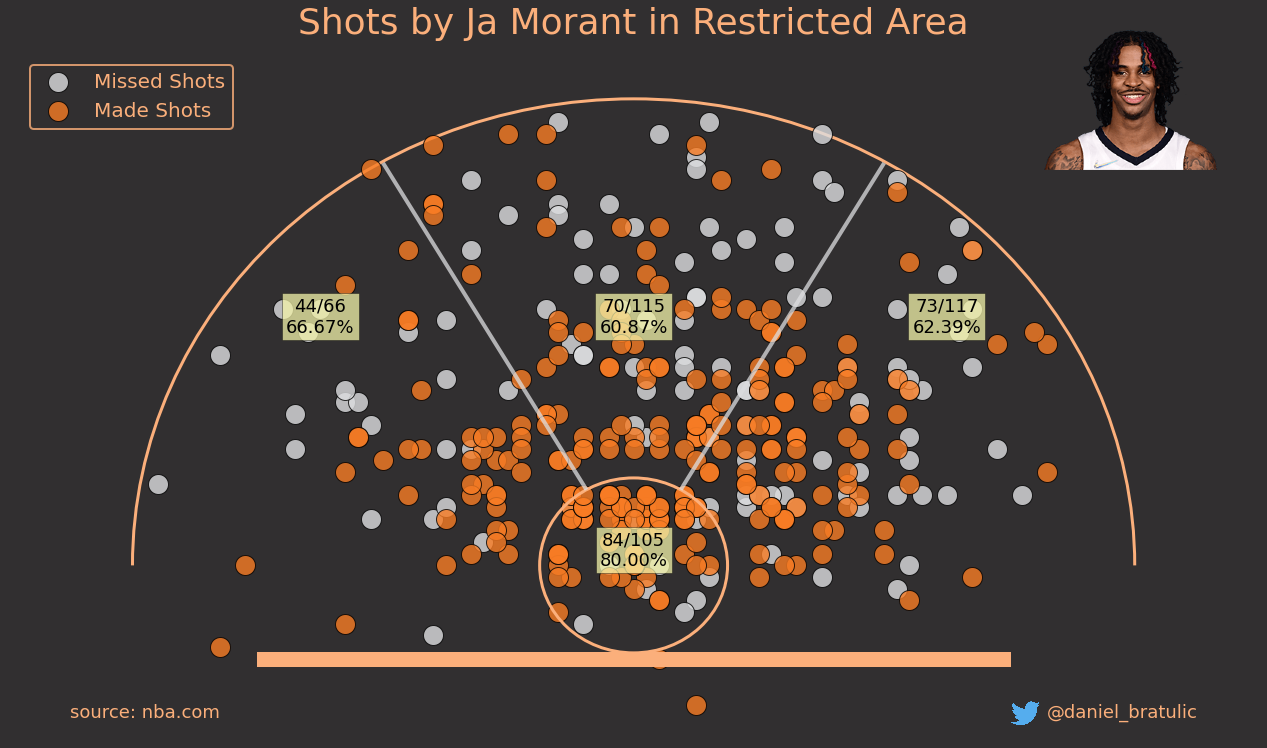

In [11]:

_ = plot_restricted_area_dark(data_frame=rim_area, title=f"Shots by {player_name} in Restricted Area", plot_image=True)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


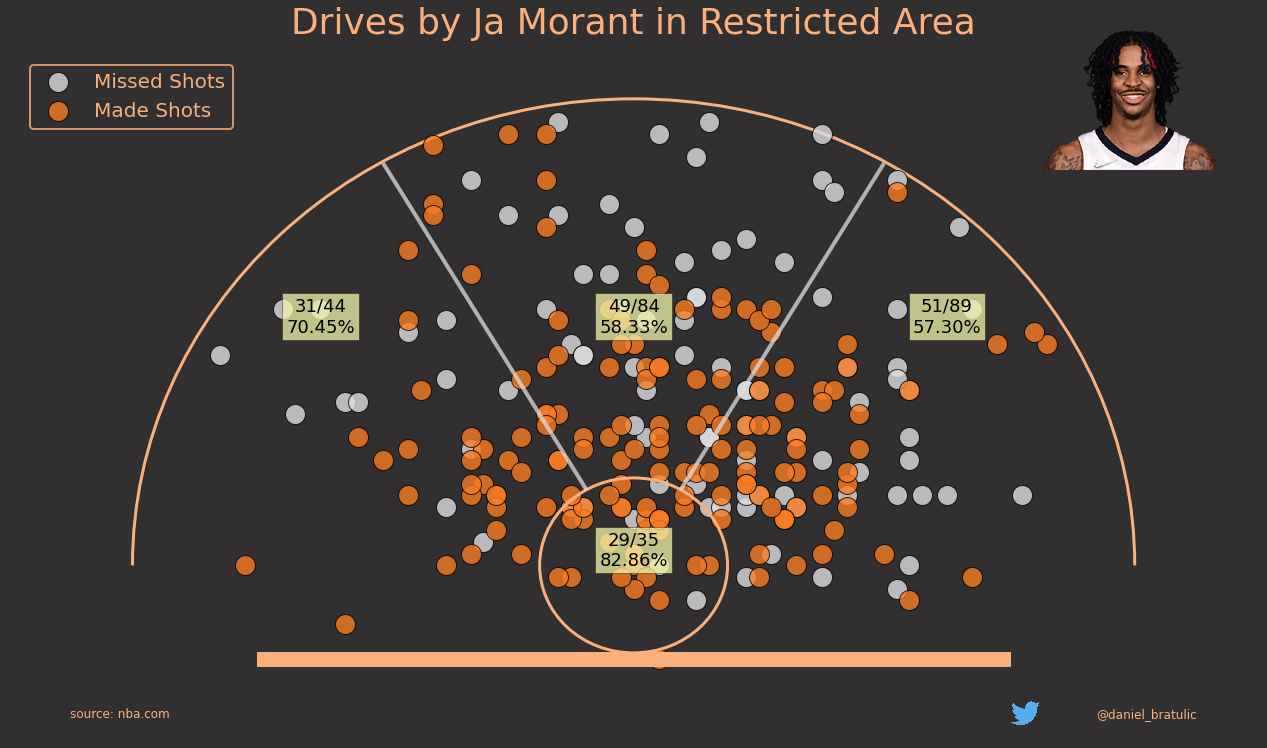

In [41]:

_ = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in Restricted Area", plot_image=True)

In [19]:
player_name = "Donovan Mitchell"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shots = ShotChartDetail(team_id=0, player_id=player_id, season_nullable='2021-22', context_measure_simple='FGA').get_data_frames()[0]

player_shots.LOC_X = -player_shots.LOC_X

rim_area = player_shots.loc[player_shots.SHOT_ZONE_BASIC == "Restricted Area"]
drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]

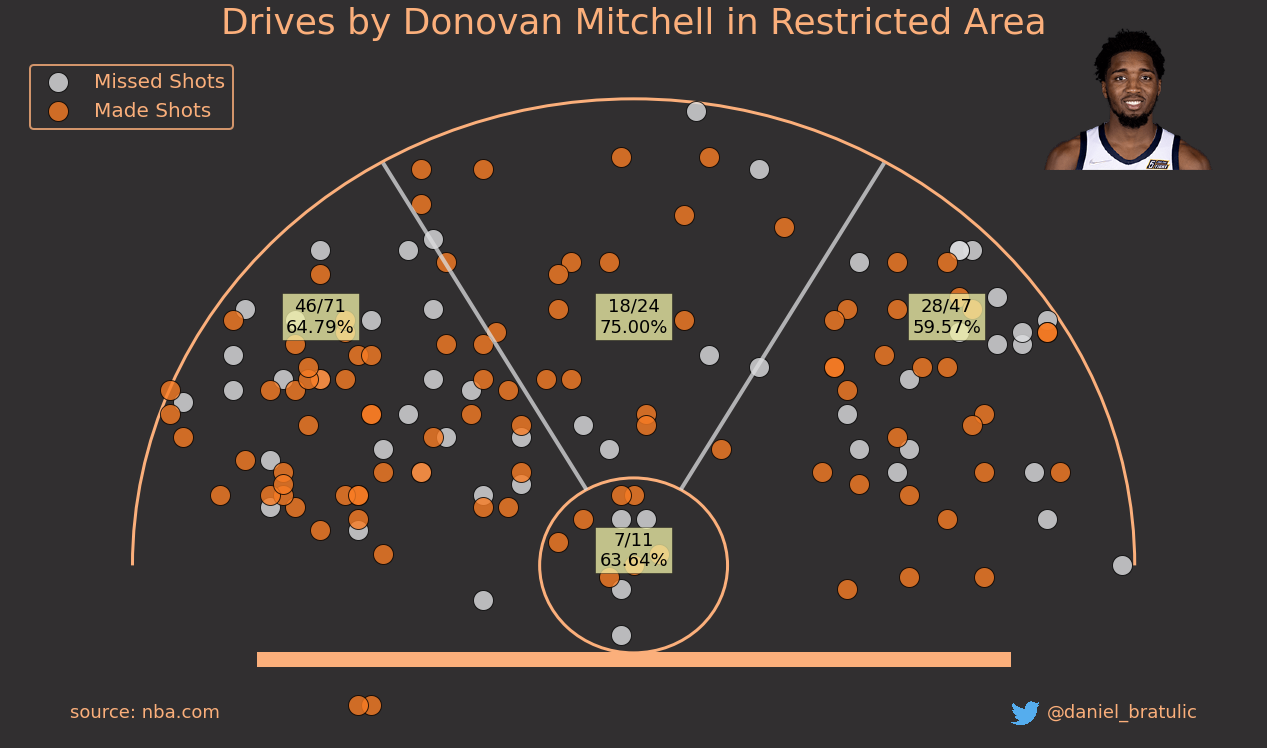

In [20]:

_ = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in Restricted Area", plot_image=True)

In [9]:
player_name = "Luka Doncic"
player_id = find_players_by_full_name(player_name)[0]['id']

player_shots = ShotChartDetail(team_id=0, player_id=player_id, season_nullable='2021-22', context_measure_simple='FGA').get_data_frames()[0]

player_shots.LOC_X = -player_shots.LOC_X

rim_area = player_shots.loc[player_shots.SHOT_ZONE_BASIC == "Restricted Area"]
drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


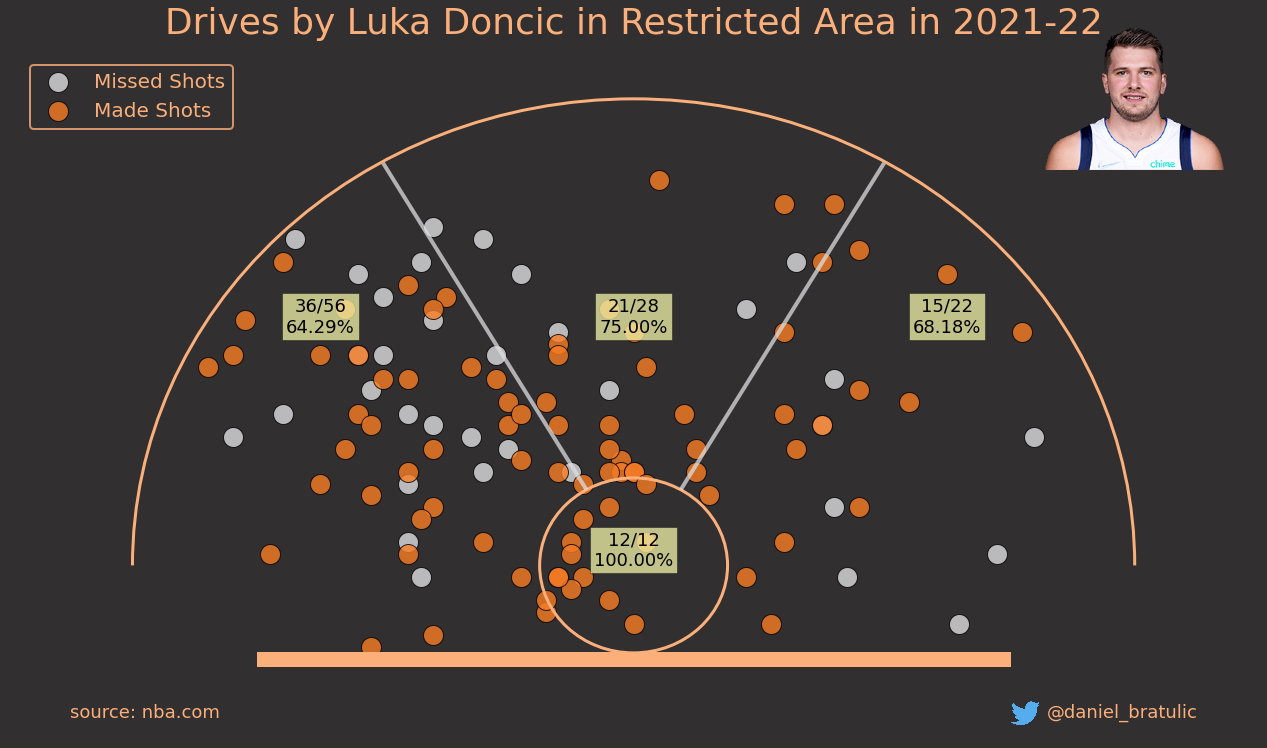

In [11]:

modified_drives = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in Restricted Area in 2021-22", plot_image=True)

## Miles Bridges

In [9]:
player_name = "Miles Bridges"
season = '2021-22'
player_id = find_players_by_full_name(player_name)[0]['id']

player_shots = ShotChartDetail(team_id=0, player_id=player_id, season_nullable=season, context_measure_simple='FGA').get_data_frames()[0]

player_shots.LOC_X = -player_shots.LOC_X

rim_area = player_shots.loc[player_shots.SHOT_ZONE_BASIC == "Restricted Area"]
drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]

In [ ]:

modified_drives = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in Restricted Area in {season}", plot_image=True)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


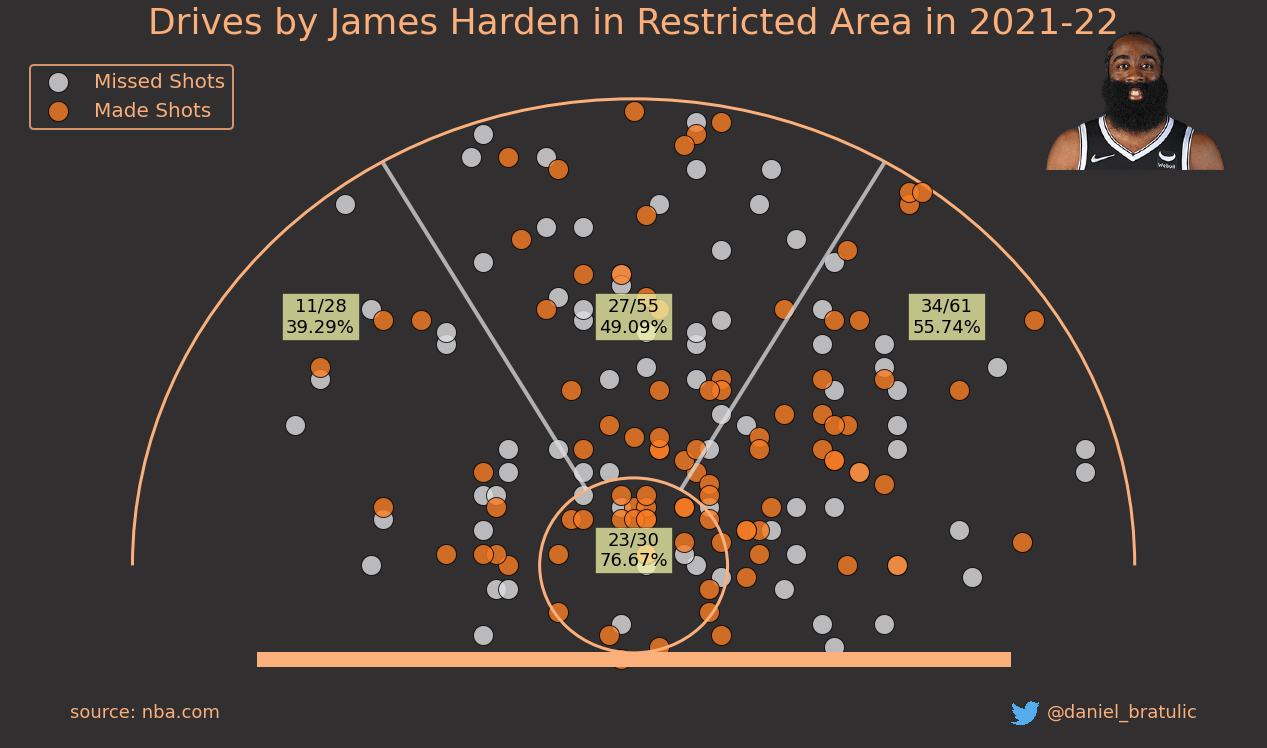

In [10]:

modified_drives = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in Restricted Area in {season}", plot_image=True)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


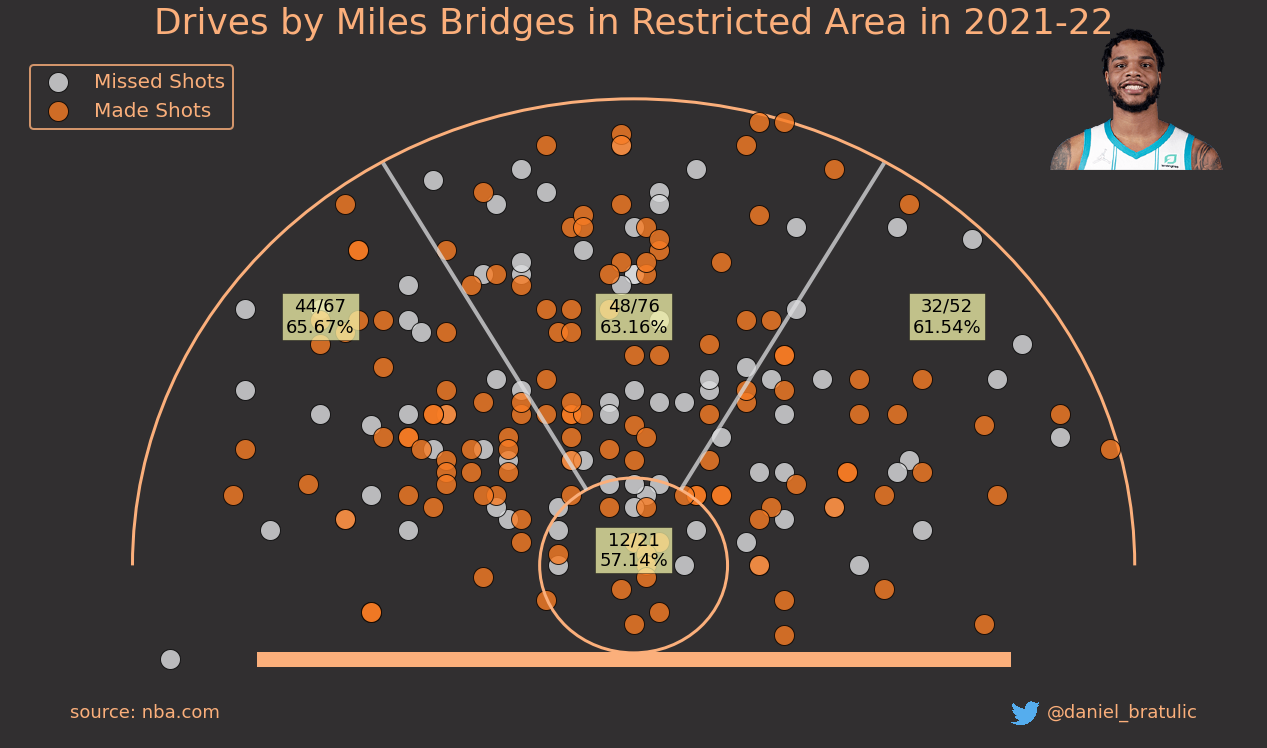

In [10]:

modified_drives = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in Restricted Area in 2021-22", plot_image=True)

## James Harden

In [10]:
player_name = "James Harden"
season = '2021-22'
player_id = find_players_by_full_name(player_name)[0]['id']

player_shots = ShotChartDetail(team_id=0, player_id=player_id, season_nullable=season, context_measure_simple='FGA').get_data_frames()[0]

player_shots.LOC_X = -player_shots.LOC_X

rim_area = player_shots.loc[player_shots.SHOT_ZONE_BASIC == "Restricted Area"]
drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


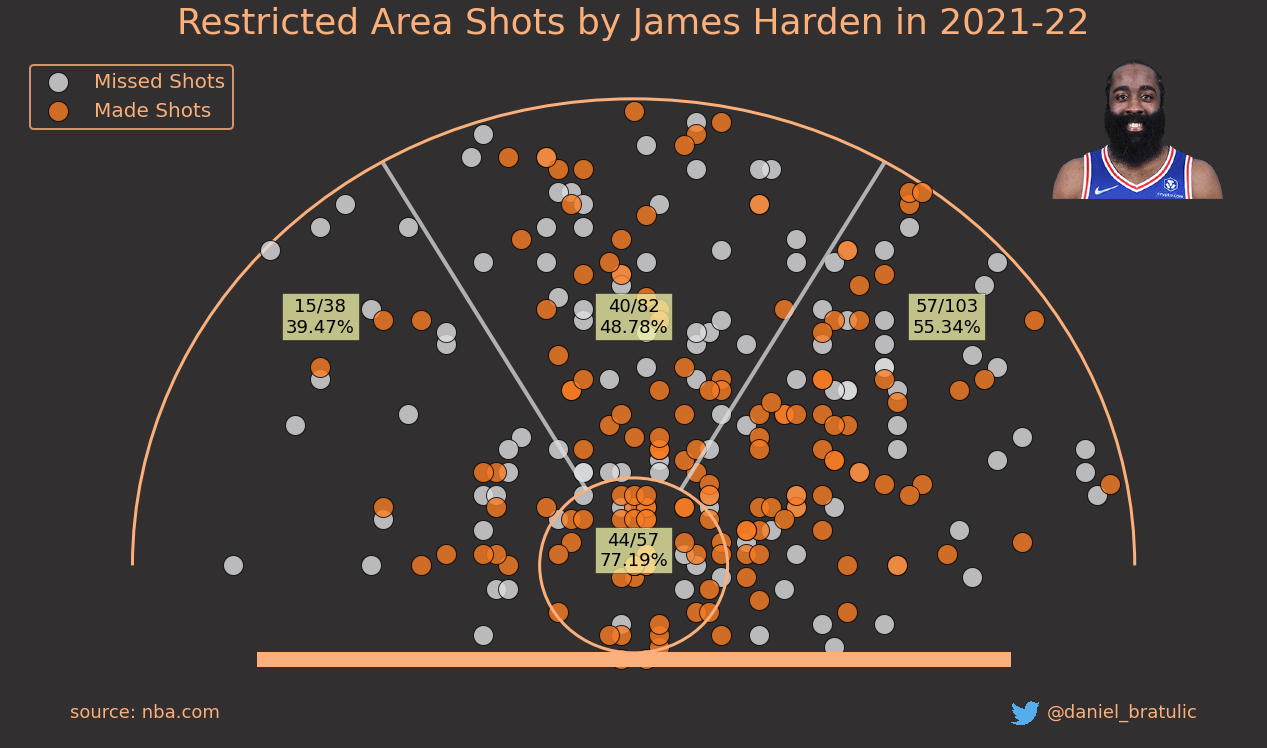

In [11]:

modified_drives = plot_restricted_area_dark(data_frame=rim_area, title=f"Restricted Area Shots by {player_name} in {season}", plot_image=True)

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\pandas\core\indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


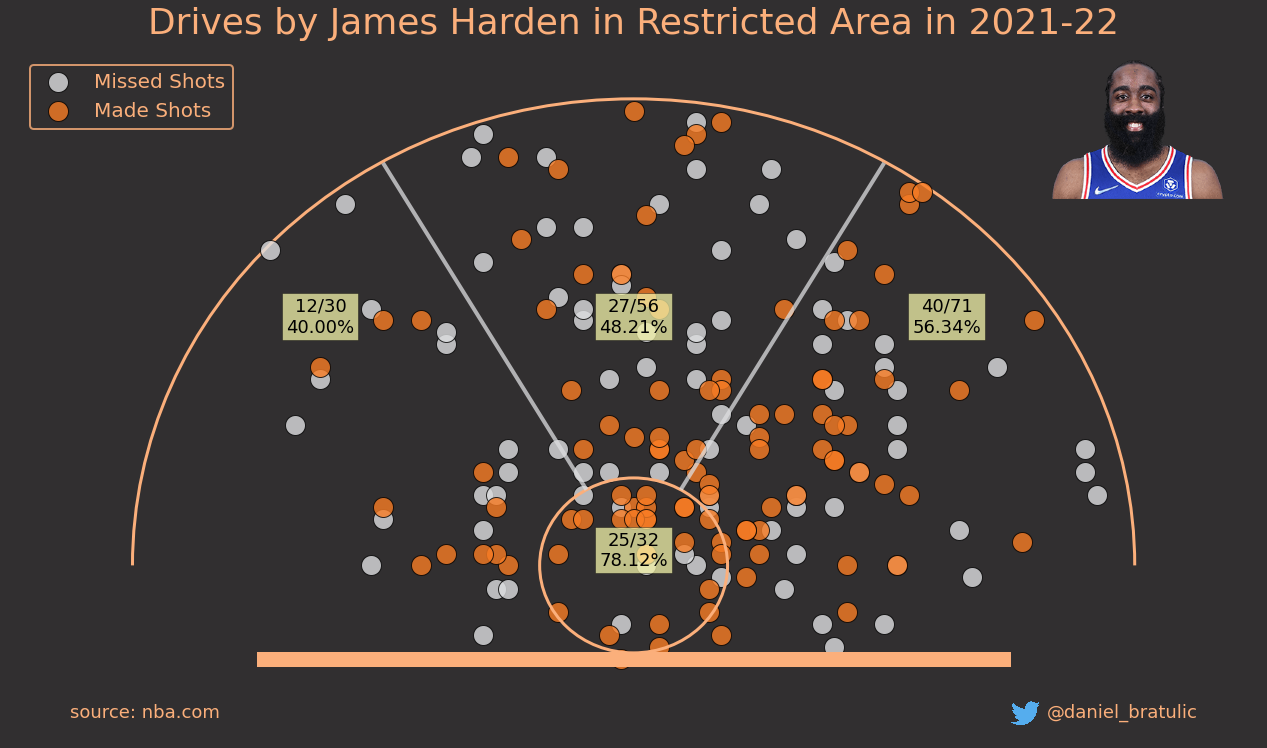

In [12]:

modified_drives = plot_restricted_area_dark(data_frame=drives, title=f"Drives by {player_name} in Restricted Area in {season}", plot_image=True)

In [278]:
modified_drives

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,AREA
9,Shot Chart Detail,0022100014,392,1629029,Luka Doncic,1610612742,Dallas Mavericks,3,7,8,...,Less Than 8 ft.,3,-17,26,1,0,20211021,ATL,DAL,RIGHT
11,Shot Chart Detail,0022100014,444,1629029,Luka Doncic,1610612742,Dallas Mavericks,3,3,19,...,Less Than 8 ft.,3,-28,26,1,1,20211021,ATL,DAL,RIGHT
28,Shot Chart Detail,0022100029,394,1629029,Luka Doncic,1610612742,Dallas Mavericks,3,9,46,...,Less Than 8 ft.,0,-2,-3,1,1,20211023,TOR,DAL,RIM
29,Shot Chart Detail,0022100029,419,1629029,Luka Doncic,1610612742,Dallas Mavericks,3,6,6,...,Less Than 8 ft.,0,6,6,1,1,20211023,TOR,DAL,RIM
37,Shot Chart Detail,0022100029,597,1629029,Luka Doncic,1610612742,Dallas Mavericks,4,6,23,...,Less Than 8 ft.,0,-6,-1,1,1,20211023,TOR,DAL,RIM
62,Shot Chart Detail,0022100052,666,1629029,Luka Doncic,1610612742,Dallas Mavericks,4,2,17,...,Less Than 8 ft.,1,-18,8,1,1,20211026,DAL,HOU,RIGHT
64,Shot Chart Detail,0022100052,684,1629029,Luka Doncic,1610612742,Dallas Mavericks,4,0,52,...,Less Than 8 ft.,1,-6,8,1,1,20211026,DAL,HOU,RIGHT
70,Shot Chart Detail,0022100069,108,1629029,Luka Doncic,1610612742,Dallas Mavericks,1,3,23,...,Less Than 8 ft.,3,32,11,1,0,20211028,DAL,SAS,LEFT
74,Shot Chart Detail,0022100069,321,1629029,Luka Doncic,1610612742,Dallas Mavericks,3,11,42,...,Less Than 8 ft.,0,-5,5,1,0,20211028,DAL,SAS,RIM
79,Shot Chart Detail,0022100069,425,1629029,Luka Doncic,1610612742,Dallas Mavericks,3,3,22,...,Less Than 8 ft.,1,-9,9,1,1,20211028,DAL,SAS,RIGHT


In [279]:
modified_drives.loc[modified_drives.GAME_ID == '0022100853']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM,AREA
868,Shot Chart Detail,0022100853,40,1629029,Luka Doncic,1610612742,Dallas Mavericks,1,8,16,...,Less Than 8 ft.,3,15,26,1,1,20220212,DAL,LAC,CENTER
885,Shot Chart Detail,0022100853,372,1629029,Luka Doncic,1610612742,Dallas Mavericks,3,5,50,...,Less Than 8 ft.,1,1,17,1,1,20220212,DAL,LAC,CENTER
888,Shot Chart Detail,0022100853,510,1629029,Luka Doncic,1610612742,Dallas Mavericks,4,6,42,...,Less Than 8 ft.,2,-11,18,1,0,20220212,DAL,LAC,RIGHT
892,Shot Chart Detail,0022100853,560,1629029,Luka Doncic,1610612742,Dallas Mavericks,4,2,35,...,Less Than 8 ft.,3,16,31,1,1,20220212,DAL,LAC,CENTER
896,Shot Chart Detail,0022100853,580,1629029,Luka Doncic,1610612742,Dallas Mavericks,4,0,44,...,Less Than 8 ft.,1,13,10,1,1,20220212,DAL,LAC,LEFT


In [280]:
modified_drives.loc[modified_drives.GAME_ID == '0022100853'].ACTION_TYPE

868         Driving Floating Jump Shot
885     Driving Finger Roll Layup Shot
888                 Driving Layup Shot
892    Driving Floating Bank Jump Shot
896                 Driving Layup Shot
Name: ACTION_TYPE, dtype: object

d=(x-x1)(y2-y1) - (y-y1)(x2-x1)



In [176]:
x = sqrt(7.5 ** 2 / (1.725 ** 2 + 1))
y = 1.725 * x

In [177]:
x

3.761478267239191

In [178]:
y

6.488550010987605

In [ ]:
ax.plot([-x, -20], [y, 34.5], color=bball_white, alpha=0.75)

In [217]:
d = (-10-(-x)) * (34.5-y) - (5 - y) * (-20 - (-x)) > 0

In [8]:
doncic_id = find_players_by_full_name("Luka Doncic")[0]['id']

In [9]:
doncic_shots = ShotChartDetail(team_id=0, player_id=doncic_id, season_nullable='2021-22', context_measure_simple='FGA').get_data_frames()[0]

doncic_shots.LOC_X = -doncic_shots.LOC_X

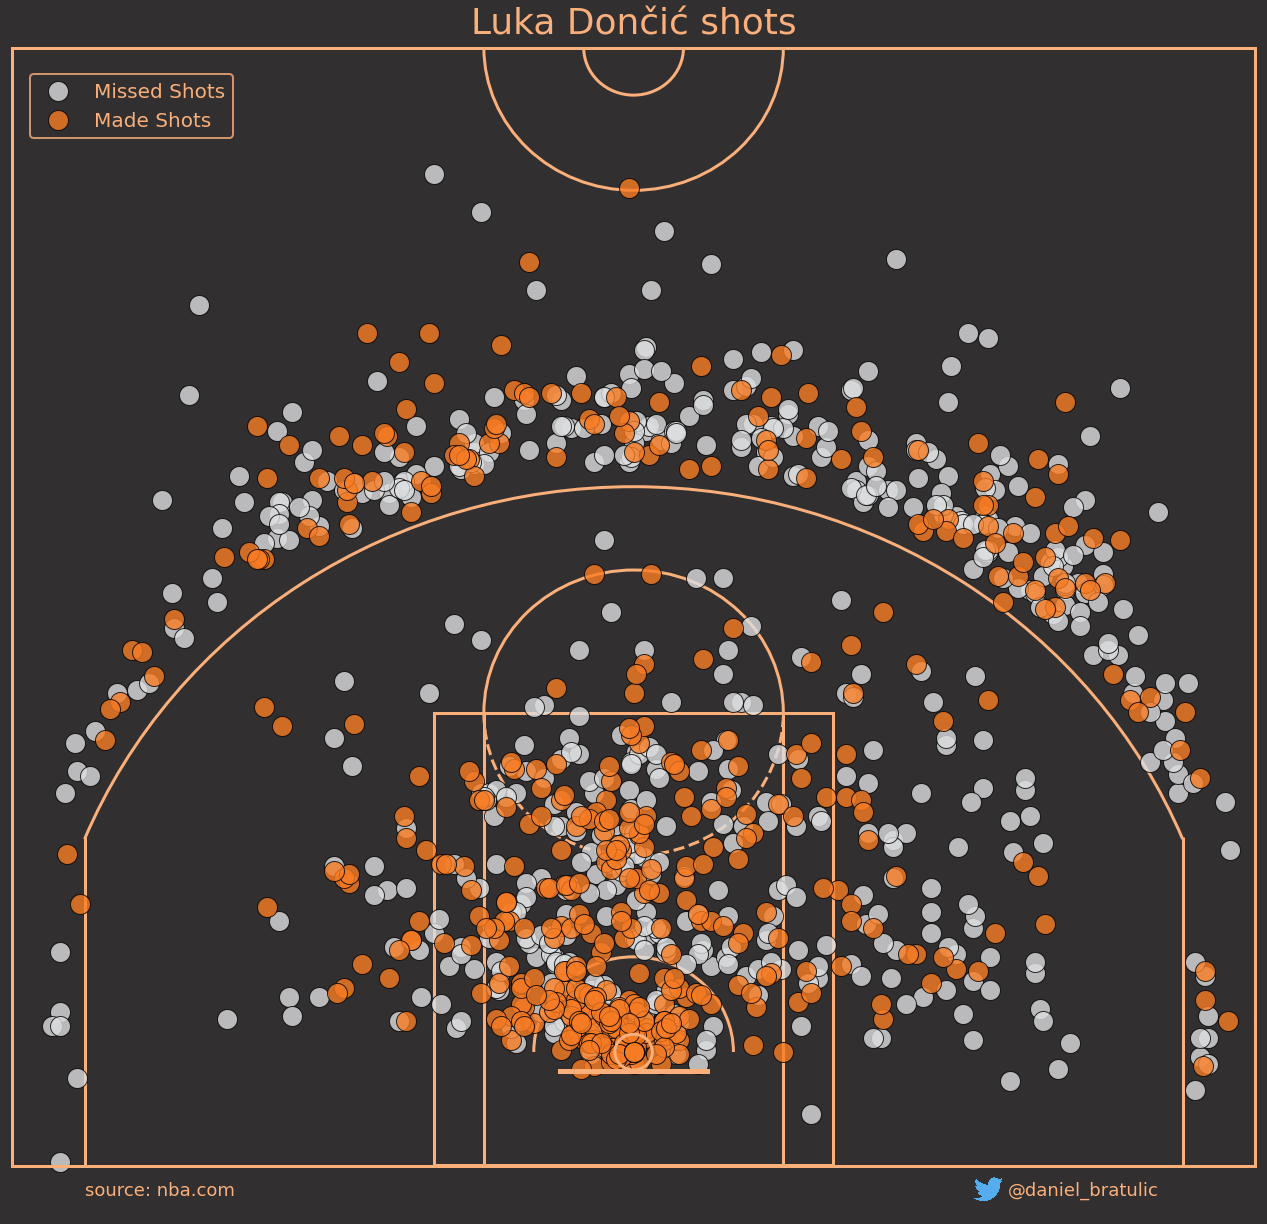

In [10]:
plot_raw_shotchart_dark(data_frame=doncic_shots, title="Luka Dončić shots")

9      -17
11     -28
28      -2
29       6
37      -6
        ..
1023    -2
1026    -9
1027   -21
1031   -10
1033   -16
Name: LOC_X, Length: 170, dtype: int64

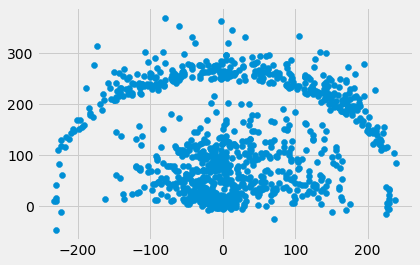

In [11]:
plt.scatter(doncic_shots.LOC_X, doncic_shots.LOC_Y)

In [12]:
rim_area = doncic_shots.loc[doncic_shots.SHOT_ZONE_BASIC == "Restricted Area"]

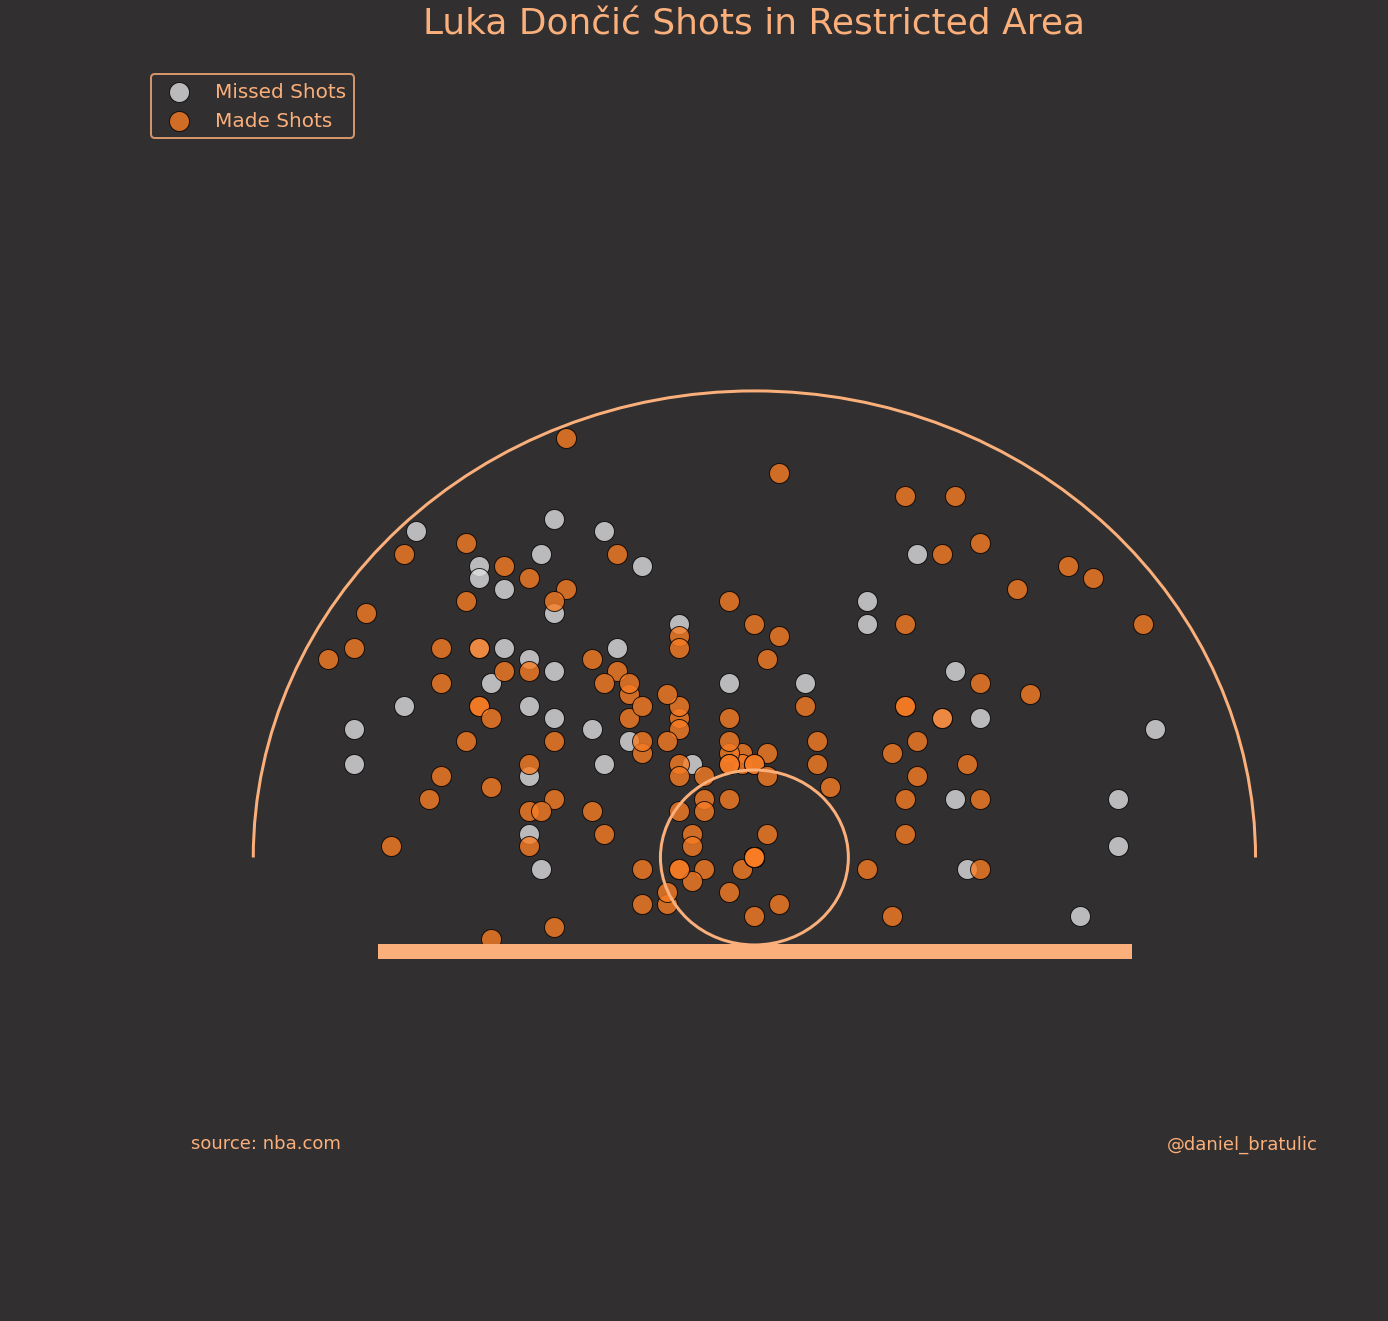

In [35]:

plot_restricted_area_dark(data_frame=rim_area, title="Luka Dončić Shots in Restricted Area")

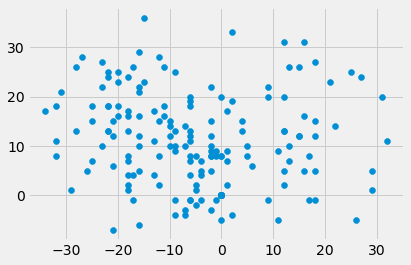

In [14]:
plt.scatter(rim_area.LOC_X, rim_area.LOC_Y)

In [15]:
rim_area.ACTION_TYPE.value_counts()

Driving Layup Shot                    65
Driving Finger Roll Layup Shot        24
Layup Shot                            15
Putback Layup Shot                    11
Driving Floating Bank Jump Shot       10
Driving Floating Jump Shot             8
Running Layup Shot                     6
Tip Layup Shot                         6
Driving Reverse Layup Shot             6
Cutting Layup Shot                     4
Driving Dunk Shot                      4
Running Finger Roll Layup Shot         4
Turnaround Fadeaway Bank Jump Shot     2
Jump Bank Shot                         1
Reverse Layup Shot                     1
Driving Bank Hook Shot                 1
Cutting Finger Roll Layup Shot         1
Tip Dunk Shot                          1
Name: ACTION_TYPE, dtype: int64

In [16]:
drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]

In [17]:
left = drives.loc[drives.LOC_X < -2]

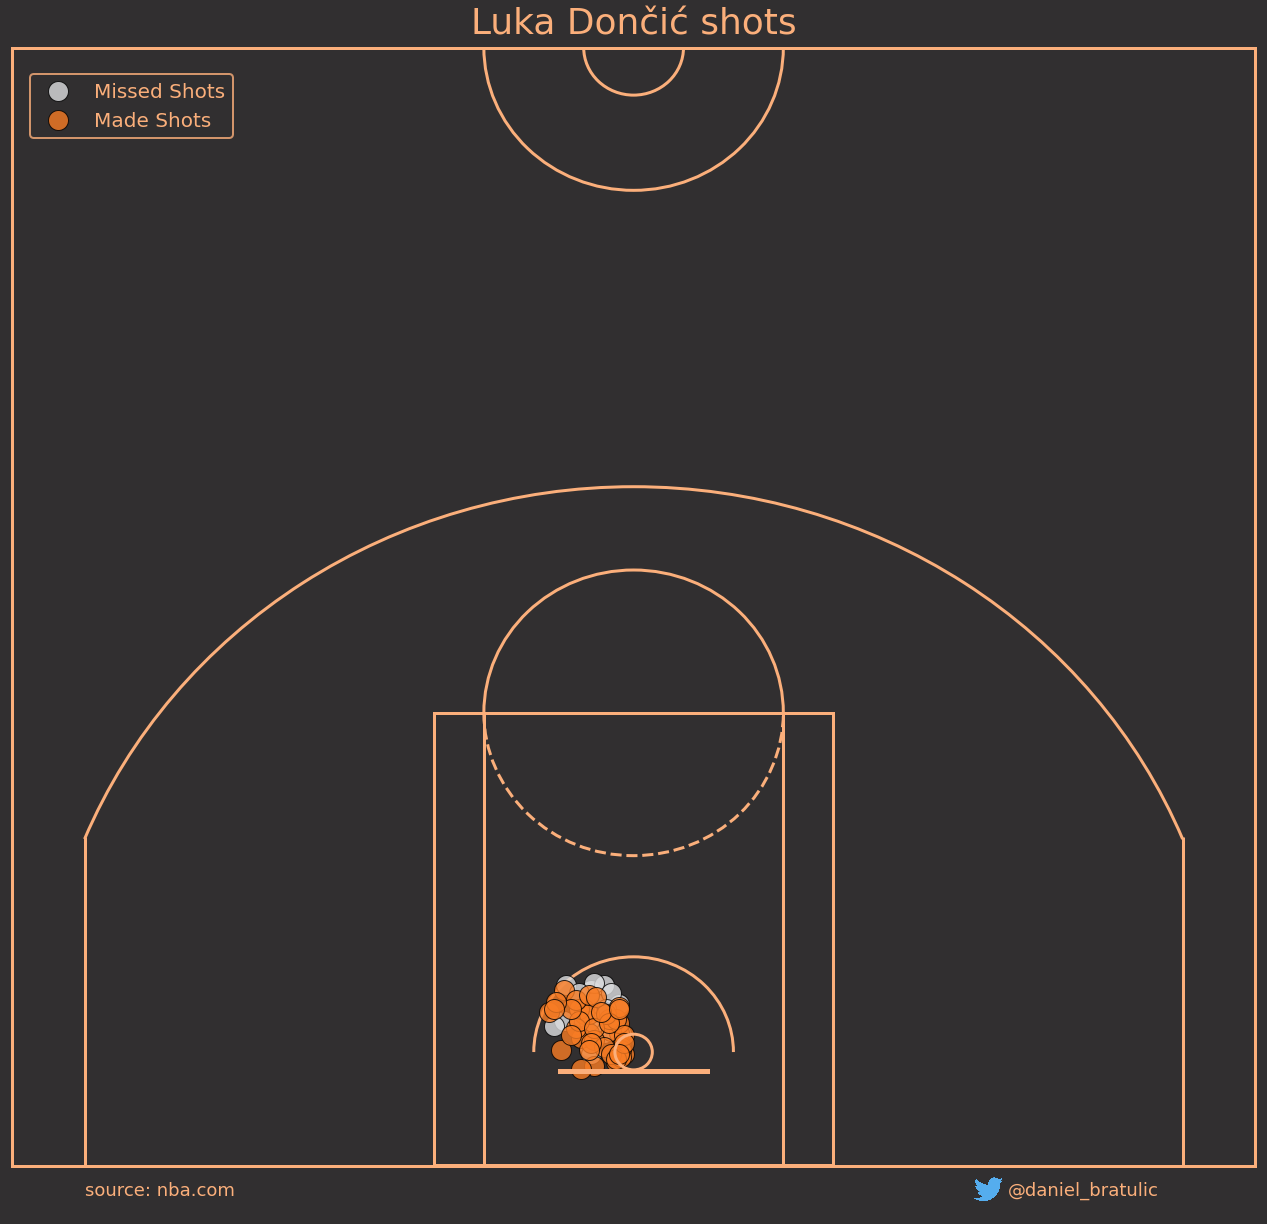

In [73]:

plot_raw_shotchart_dark(data_frame=left, title="Luka Dončić shots")

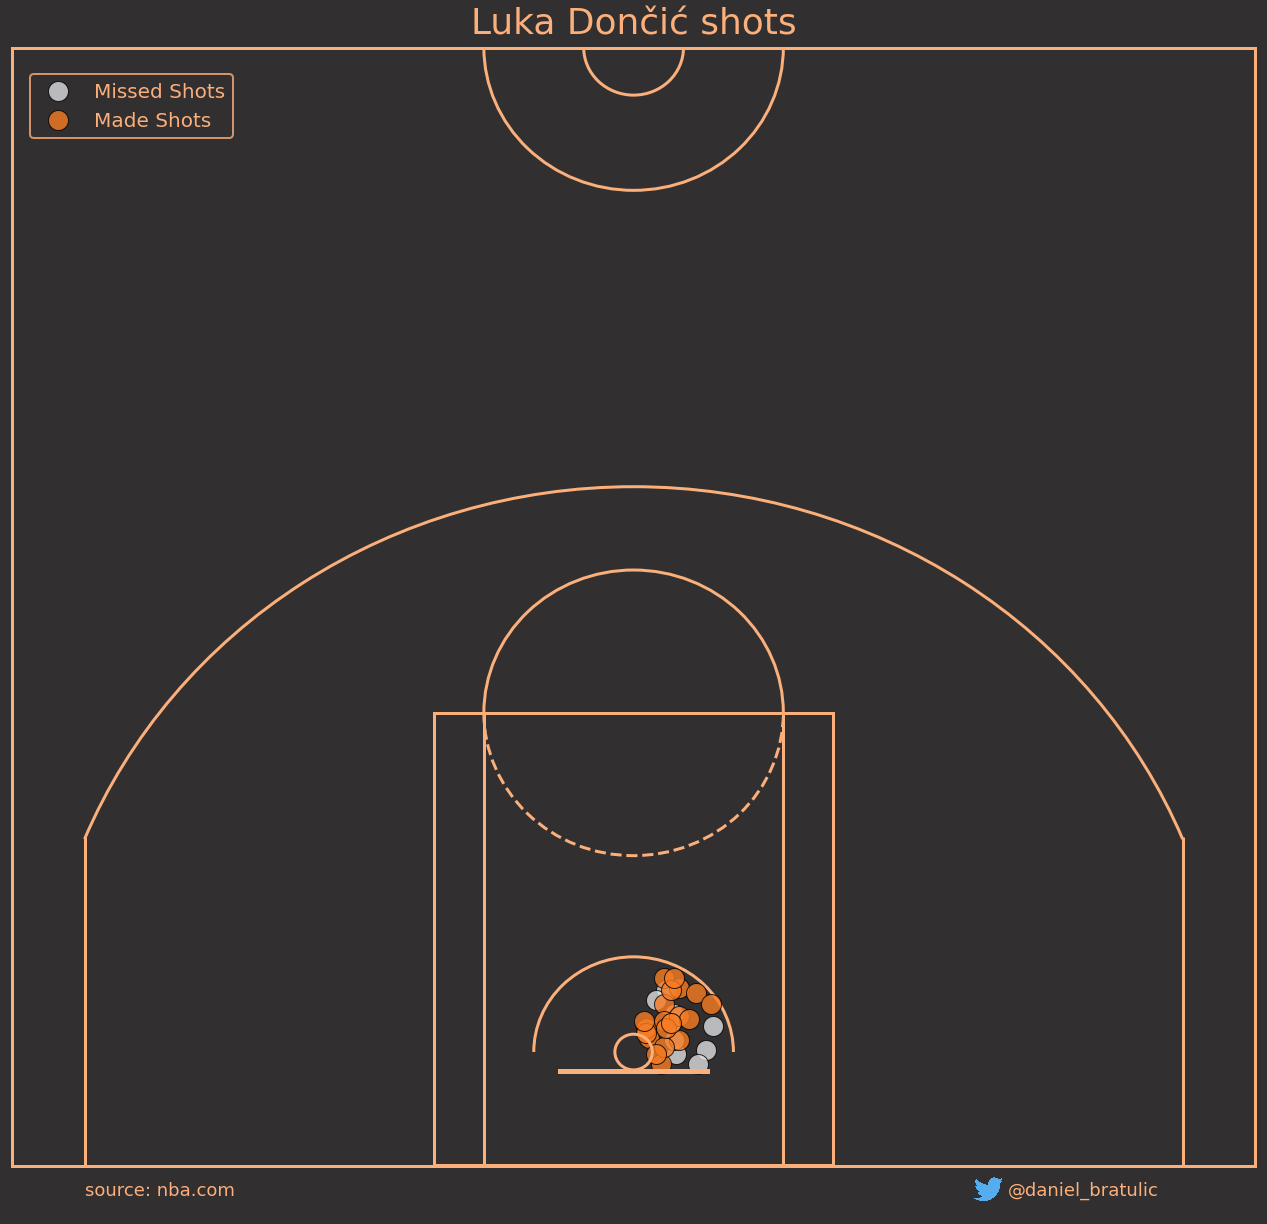

In [34]:
right = drives.loc[drives.LOC_X > 2]


plot_raw_shotchart_dark(data_frame=right, title="Luka Dončić shots")

In [ ]:
# Restricted Zone, it is an arc with 4ft radius from center of the hoop - 0, 0, 80, 80
# Create the basketball hoop
# Diameter of a hoop is 18" so it has a radius of 9", which is a value
# 7.5 in our coordinate system
hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
three_arc = Arc((0, 0), 475, 475, theta1=22.13, theta2=157.87, linewidth=lw,
                    color=color, zorder=0)

In [156]:
slope = (34.5 - 0) / 20

2.9756250000000004

In [164]:
x = sqrt(7.5 ** 2 / (1.725 ** 2 + 1))

In [165]:
y = 1.725 * x

In [166]:
y

6.488550010987605

y = 1.725 * x

x^2 + y^2 = 7.5^2

x^2 + (1.725*x)^2 = 7.5^2



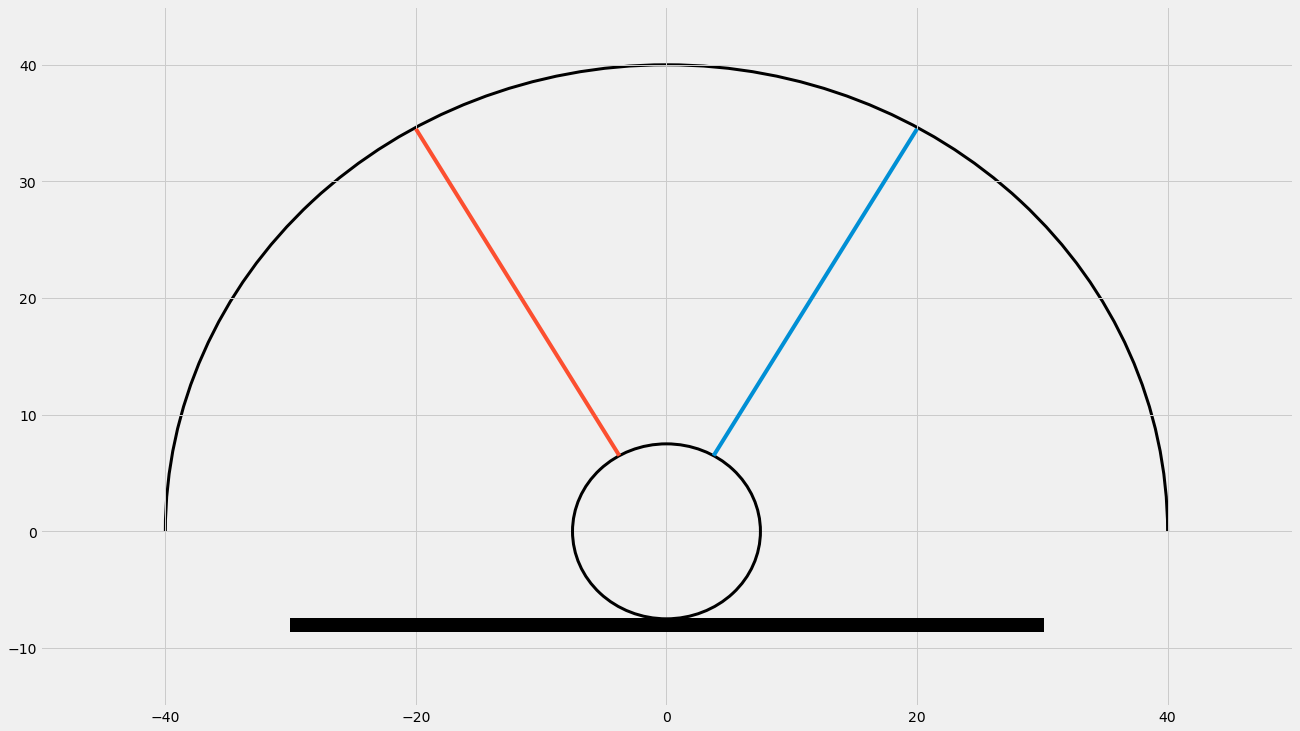

In [169]:
fig, ax = plt.subplots(figsize=(20, 12))
draw_court(ax=ax,outer_lines=True, lw=3, color='black')
ax.set_xlim(-50,50)
ax.set_ylim(-15,45)

#ax.plot([0, -20], [0, 34.5])
#ax.plot([0, 20], [0, 34.5])

x = sqrt(7.5 ** 2 / (1.725 ** 2 + 1))
y = 1.725 * x

ax.plot([x, 20], [y, 34.5])
ax.plot([-x, -20], [y, 34.5])

In [122]:
c = 40 * cos(radians(45))

In [123]:
a = sin(radians(45)) * c

In [129]:
degrees(atan(40/40))

45.0

In [133]:
tan(radians(60)) * 40

69.28203230275507

In [124]:
a

20.000000000000004

In [125]:
c

28.284271247461902

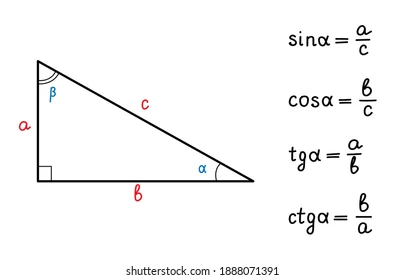

## Harden analysis

In [12]:
player_name = "James Harden"
season = '2018-19'
player_id = find_players_by_full_name(player_name)[0]['id']

player_shots = ShotChartDetail(team_id=0, player_id=player_id, season_nullable=season, context_measure_simple='FGA').get_data_frames()[0]

player_shots.LOC_X = -player_shots.LOC_X

rim_area = player_shots.loc[player_shots.SHOT_ZONE_BASIC == "Restricted Area"]
drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]

In [13]:
_LEFT = 'LEFT'
_RIGHT = 'RIGHT'
_CENTER = 'CENTER'
_RIM = 'RIM'

def calculate_restricted_area_fields(data_frame):
    areas = []
    data_frame.loc[:, 'REAL_DISTANCE'] = (data_frame.LOC_X ** 2 + data_frame.LOC_Y ** 2) ** 0.5
    x = sqrt(7.5 ** 2 / (1.725 ** 2 + 1))
    y = 1.725 * x

    for index in range(len(data_frame)):
        item = data_frame.iloc[index]
        target_x = item.LOC_X
        target_y = item.LOC_Y

        if item.REAL_DISTANCE < 7.5:
            areas.append(_RIM)
            continue
        negative_d = (target_x - (-x)) * (34.5-y) - (target_y - y) * (-20 - (-x)) < 0
        positive_d = (target_x - (x)) * (34.5-y) - (target_y - y) * (20 - (x)) > 0
        if negative_d:
            areas.append(_RIGHT)
        elif positive_d:
            areas.append(_LEFT)
        else:
            areas.append(_CENTER)


    data_frame.loc[:, 'AREA'] = areas
    return data_frame

In [14]:
modified = calculate_restricted_area_fields(drives)

In [15]:
seasons = [f"{season}-{str(season+1)[-2:]}" for season in range(2012, 2022)]

In [16]:
all_dfs = []
for season in seasons:
    player_name = "James Harden"
    player_id = find_players_by_full_name(player_name)[0]['id']

    player_shots = ShotChartDetail(team_id=0, player_id=player_id, season_nullable=season, context_measure_simple='FGA').get_data_frames()[0]
    player_shots.LOC_X = -player_shots.LOC_X
    player_shots.loc[:, 'SEASON'] = season
    all_dfs.append(player_shots)
    time.sleep(1)

In [17]:
full_harden = pd.concat(all_dfs)

In [18]:
ra_breakdown = []
for season in seasons:
    cur_df = full_harden.loc[full_harden.SEASON == season]

    rim_area = cur_df.loc[cur_df.SHOT_ZONE_BASIC == "Restricted Area"]
    #drives = rim_area.loc[rim_area.ACTION_TYPE.str.contains('Driving')]
    modified = calculate_restricted_area_fields(rim_area)
    #dict_data = modified.groupby('AREA').size().to_dict()
    temp = modified.groupby('AREA').agg(
        {
            'SHOT_MADE_FLAG': 'sum',
            'SHOT_ATTEMPTED_FLAG': 'sum'
        }
    ).reset_index()
    temp.loc[:, 'SHOT_PCT'] = temp.SHOT_MADE_FLAG / temp.SHOT_ATTEMPTED_FLAG * 100
    temp.loc[:, 'SEASON'] = season
    ra_breakdown.append(temp)

In [19]:
ra_df = pd.concat(ra_breakdown)

In [20]:
ra_df.head()

,AREA,SHOT_MADE_FLAG,SHOT_ATTEMPTED_FLAG,SHOT_PCT,SEASON
0,CENTER,70,119,58.823529,2012-13
1,LEFT,90,157,57.324841,2012-13
2,RIGHT,40,83,48.192771,2012-13
3,RIM,80,104,76.923077,2012-13
0,CENTER,60,102,58.823529,2013-14


In [21]:
ra_df.SHOT_PCT.tolist()

[58.82352941176471,
 57.324840764331206,
 48.19277108433735,
 76.92307692307693,
 58.82352941176471,
 54.263565891472865,
 61.33333333333333,
 80.64516129032258,
 47.82608695652174,
 54.90196078431373,
 56.56565656565656,
 73.91304347826086,
 54.43037974683544,
 61.08949416342413,
 53.94736842105263,
 81.81818181818183,
 63.20754716981132,
 64.55696202531645,
 64.28571428571429,
 72.22222222222221,
 57.46268656716418,
 60.9375,
 67.21311475409836,
 73.01587301587301,
 59.58549222797927,
 57.07547169811321,
 53.2258064516129,
 69.23076923076923,
 63.30935251798561,
 60.273972602739725,
 60.0,
 82.75862068965517,
 58.730158730158735,
 55.69620253164557,
 69.76744186046511,
 85.18518518518519,
 48.78048780487805,
 54.08163265306123,
 38.88888888888889,
 76.78571428571429]

[Text(-0.5, 0, ''),
 Text(0.0, 0, ''),
 Text(0.5, 0, ''),
 Text(1.0, 0, ''),
 Text(1.5, 0, ''),
 Text(2.0, 0, ''),
 Text(2.5, 0, '')]

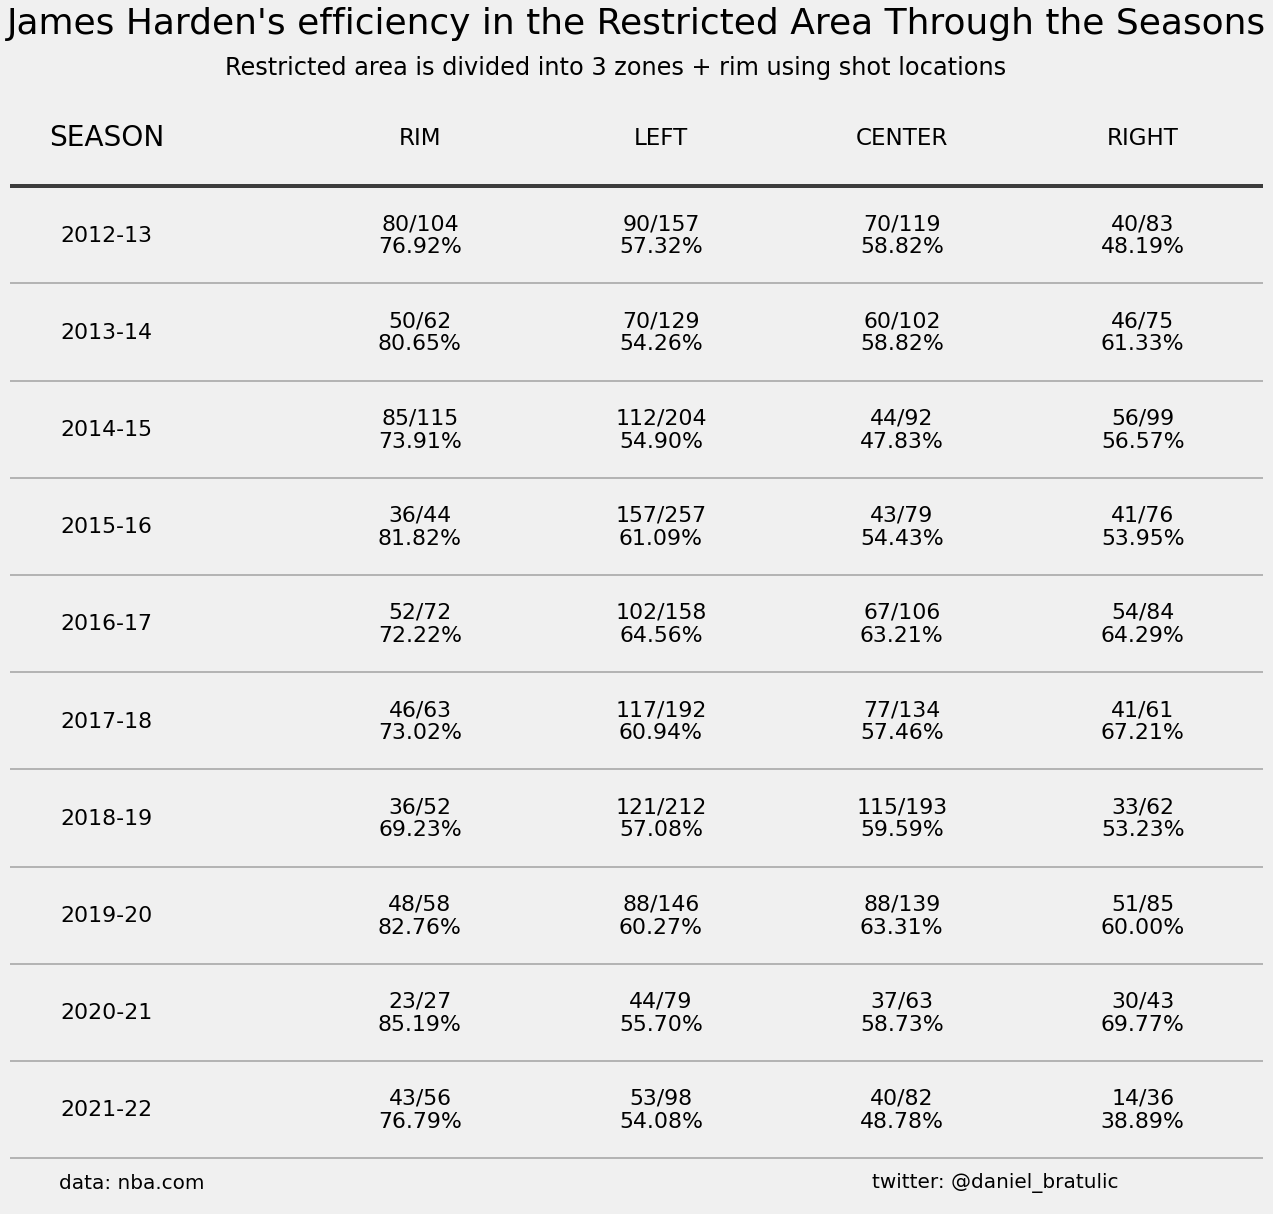

In [22]:
fig, ax = plt.subplots(figsize=(20, 20))
font_size = 22
font_title = 28
top = len(seasons)
#top = 10

for i in range(len(seasons)):
    season = seasons[i]
    y_coord = top - i - 1
    if i % 2 == 1:
        color = '#EAE8E8'
        #rect = Rectangle((-0.5, y_coord + 0.5), width=5, height=1, fill=True, color=color)
        #ax.add_patch(rect)
    target_data = ra_df.loc[ra_df.SEASON == season]
    ax.text(x=0.1, y=y_coord, ha='center', va='center', s=season, size=font_size)
    ax.axhline(y=y_coord-0.5, xmin=-0.25, xmax=10, color='#A0A0A0', alpha=0.75, lw=2)
    
    area_data = target_data.loc[target_data.AREA == 'RIM'].iloc[0]
    ax.text(x=0.75, y=y_coord, ha='center', va='center',
           s=f"{area_data.SHOT_MADE_FLAG}/{area_data.SHOT_ATTEMPTED_FLAG}\n{area_data.SHOT_PCT:.2f}%", size=font_size)
    
    area_data = target_data.loc[target_data.AREA == 'LEFT'].iloc[0]
    ax.text(x=1.25, y=y_coord, ha='center', va='center',
           s=f"{area_data.SHOT_MADE_FLAG}/{area_data.SHOT_ATTEMPTED_FLAG}\n{area_data.SHOT_PCT:.2f}%", size=font_size)
    
    area_data = target_data.loc[target_data.AREA == 'CENTER'].iloc[0]
    ax.text(x=1.75, y=y_coord, ha='center', va='center',
           s=f"{area_data.SHOT_MADE_FLAG}/{area_data.SHOT_ATTEMPTED_FLAG}\n{area_data.SHOT_PCT:.2f}%", size=font_size)
    
    area_data = target_data.loc[target_data.AREA == 'RIGHT'].iloc[0]
    ax.text(x=2.25, y=y_coord, ha='center', va='center',
           s=f"{area_data.SHOT_MADE_FLAG}/{area_data.SHOT_ATTEMPTED_FLAG}\n{area_data.SHOT_PCT:.2f}%", size=font_size)
    
    

#ax.text(x=0.5, y=top, ha='center', va='center', s="TEAM", size=font_title)    
ax.text(x=0.1, y=top, s='SEASON', ha='center', va='center', size=font_title)
ax.text(x=0.75, y=top, ha='center', va='center', s="RIM", size=font_title-5)
ax.text(x=1.25, y=top, ha='center', va='center', s="LEFT", size=font_title-5)
ax.text(x=1.75, y=top, ha='center', va='center', s="CENTER", size=font_title-5)
ax.text(x=2.25, y=top, ha='center', va='center', s="RIGHT", size=font_title-5)


ax.text(x=2.2, y=-0.75, s='twitter: @daniel_bratulic', ha='right', va='center', size=20)
ax.text(x=0, y=-0.75, s='data: nba.com', ha='left', va='center', size=20)
ax.axhline(y=top-0.5, xmin=-0.25, xmax=10, color='black', alpha=0.75, lw=4)
ax.set_title("James Harden's efficiency in the Restricted Area Through the Seasons", size=36)
plt.suptitle("Restricted area is divided into 3 zones + rim using shot locations", y=0.870, size=24)
    
ax.set_ylim(bottom=-1, top=top+1)
ax.set_xlim(left=-0.1, right=2.5)
ax.grid(False)
ax.set_frame_on(False)
ax.set_yticklabels([])
ax.set_xticklabels([])
#plt.savefig('slika.png', dpi=120, bbox_inches='tight')

In [103]:
modified.groupby('AREA').size().to_dict()

{'CENTER': 80, 'LEFT': 90, 'RIGHT': 36, 'RIM': 55}